<center><b>DSA4212</b></center>
<center><b>Semester 2 AY21/22</b></center>
<center><b>Assignment 1</b></center>



<center>Group Number: 34  </center>
<center>Group Member 1: Shaunn Tan De Hui, A0087785H  </center>
<center>Group Member 2: Zhang Shaoxuan, A0080411X  </center>
<center>Group Member 3: Ong Jian Ying Gary, A0155664X  </center>
<center>Group Member 4: Lu Zhengjie, A0067082E  </center>

# Summary
In this Assignment, we attempt to perform a classification task on a subset of the CelebFaces Attributes Dataset (CelebA) dataset.

Comprising 20,000 images and the corresponding attributes of each picture, we attempt to perform classification of each image to the binary Gender class: {Male, Female}.

The training of models will be performed using the first 15,000 images, while the performance of each model will be assessed based on the remaining 5,000 images.

The organisation of the jupyter notebook & the accompanying report will be as follows:
1. provide summary information about the dataset,
1. discuss the preprocessing steps for the pictures before they are used for model training,
1. propose the models that we will experiment with, and select the best model to address questions relating to the task
1. address the following questions (part of Assignment 1):
    1. how does the accuracy of the prediction change with the size of the training set?
    2. how does the accuracy of the prediction change with resolution of the input images?
    3. compare the performance of the model using colored vs grayscale images.
    4. compare the performance of the models using various parts of the faces
    5. compare ensemble models
    6. identify a model with good performance if the data input is limited

Where relevant, the performance measured using accuracy of prediction on the test set will be presented.

In [ ]:
# Import all the required packages

%matplotlib inline
import imageio as iio
from PIL import Image

from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy
import jax
import jax.numpy as jnp

# to install joblib: !pip install joblib
# for parallel processing some functions
from joblib import Parallel, delayed

import os

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

# to install imageio: !pip install imageio

# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist, adjust_gamma, adjust_log

# to install scikit-learn: !pip install scikit-learn
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Specify the working directory
data_root = "./"
data_root_images = "../Datasets/"

In [ ]:
plt.rcParams['font.size'] = '10'

# Dataset
The CelebA dataset is a face attributes dataset, with the full dataset comprising 200 thousand images of celebrities and 40 attributes are accorded to image. 

The dataset used for this classification task is a subset comprising 20 thousand images, of which the first 15,000 will be used for training, while the remaining 5,000 will be used to assess the performance of each model. Each image has dimensions 218px by 178px, with 3 RGB channels.

The classification task in this report is to determine is the individual in an image is "Male" or "Female".

In [ ]:
# read in attributes file.
attribute = pd.read_csv(data_root + "celeba.csv")
attr_train, attr_test = np.array(attribute['Male'][0:15000]), np.array(attribute['Male'][15000:20000])

# load img file list
path = data_root + "img_celeba_small/"
all_img = [path + f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

# split filenames of images to train and test sets
img_train, img_test = all_img[0:15000], all_img[15000:]
print(f'No. of images in train/test: {len(img_train)}, {len(img_test)}')

Number of images: 20000
No. of images in train/test: 15000, 5000


Grouping by the set each observation belongs to, we noted that the proportion of Male vs Female images is balanced and are similar for both the train and test sets.

In [ ]:
gender = pd.DataFrame(attribute['Male'])
gender.loc[0:15000,'Set'] = "Train"
gender.loc[15000:,'Set'] = "Test"
proportions = pd.DataFrame(round(gender.groupby(['Set','Male']).size()/gender.groupby(['Set']).size(), 2), columns = ['Proportion'])
proportions

Proportion
Set   Male            
Test  -1          0.58
       1          0.42
Train -1          0.58
       1          0.42

# Preprocessing
Before any training can be performed, we will perform the following preprocessing steps in order:

1. An image size parameter will be defined as a hyperparameter and all input images for training and testing will be reshaped into the specified dimension (e.g. 200px by 200px)
1. Images will be converted to grayscale
1. Enhance the contrast of each image using `skimage.exposure.equalize_adapthist`

We create utility functions to perform this preprocessing task and attempt to parallelize the reading in and processing of images using `joblib`.

Finally, we perform dimensionality reduction using PCA. The PCA procedure will be performed from a randomly drawn sample of 1,000 images from the training set. The PCA process shall be performed using prebuilt functions in `scikit-learn`.

In [ ]:
# Create utility functions for reading images

def readimg(filepath, imgsize, enhance_contrast, convert_grayscale):
    '''
    Read an image, resize and convert to grayscale
    
    Params
    ---
    filepath: String
        path to image file
        
    imgsize: int
        width of output square image
        
    Returns:
    ---
    ndarray:
        (imgsize,imgsize) image as float
    '''
    img = iio.imread(filepath).astype(float)/255
    
    img = resize(img, (imgsize,imgsize))
    
    if enhance_contrast:
        img = equalize_adapthist(img)
    
    if convert_grayscale:
        img = rgb2gray(img)
    
    return img

def readflattenedimg(filepath, imgsize, enhance_contrast = True, convert_grayscale = True):
    '''
    Read an image, resize and convert to grayscale and flatten into vector
    
    Params
    ---
    filepath: String
        path to image file
        
    imgsize: int
        width of output square image
        
    Returns:
    ---
    ndarray:
        image as float vector
    '''
    img = readimg(filepath, imgsize, enhance_contrast, convert_grayscale)
    
    return np.reshape(img, -1)

def genpcadataset(imgsize, imgtrain, n_samples, enhance_contrast = True, convert_grayscale = True):
    '''
    Generates nd.array of images to be used for PCA
    
    Params
    ---
    imgsize: int
        output image size
    
    imgtrain: list
        filepaths of images
        
    n_samples: int
        number of samples to be used for PCA
        
    Returns:
    ---
    ndarray:
        (n_samples, imgsize * imgsize) nd.array of flattened images
    '''
    # set random seed for reproducibility
    np.random.seed(0)

    # Create an array of n_samples indices for PCA. 
    pca_indices = np.random.choice(len(imgtrain), size = n_samples, replace = False).astype(int)
    pca_indices.sort()
    pca_indices = pca_indices.astype(int)
    
    # Load 1,000 images into memory for PCA
    pca_filepaths = np.array(imgtrain)[pca_indices]
    pca_imgdata = Parallel(n_jobs = -2)(delayed(readflattenedimg)(f,imgsize, enhance_contrast, convert_grayscale) for f in pca_filepaths)
    pca_imgdata = np.vstack(pca_imgdata)
    
    return pca_imgdata

def performpca(imgdata, n_components):
    '''
    Takes in ndarray and perform PCA. Returns a fitted PCA transformer
    
    Params
    ---
    imgdata: ndarray
        ndarray of flattened pictures for PCA
    
    n_components: int
        number of pricipal components to retain in the fitted transformer
        
    Returns:
    ---
    obj:
        Fitted PCA transformer 
    '''
    pca = PCA(n_components)
    PCA_transformer = pca.fit(imgdata)
    return PCA_transformer

## PCA
We define an arbitrarily selected 200 Principal Components to retain. A PCA transformer is fitted using the 1,000 randomly selected images. Each image is preprocessed according to the 3 steps mentioned previously.

In [ ]:
# Params
imgsize = 200
n_components = 200

pca_trainsample = genpcadataset(imgsize, img_train, 1000)
pca_transformer = performpca(pca_trainsample, n_components)
pca_transformedsample = pca_transformer.transform(pca_trainsample)

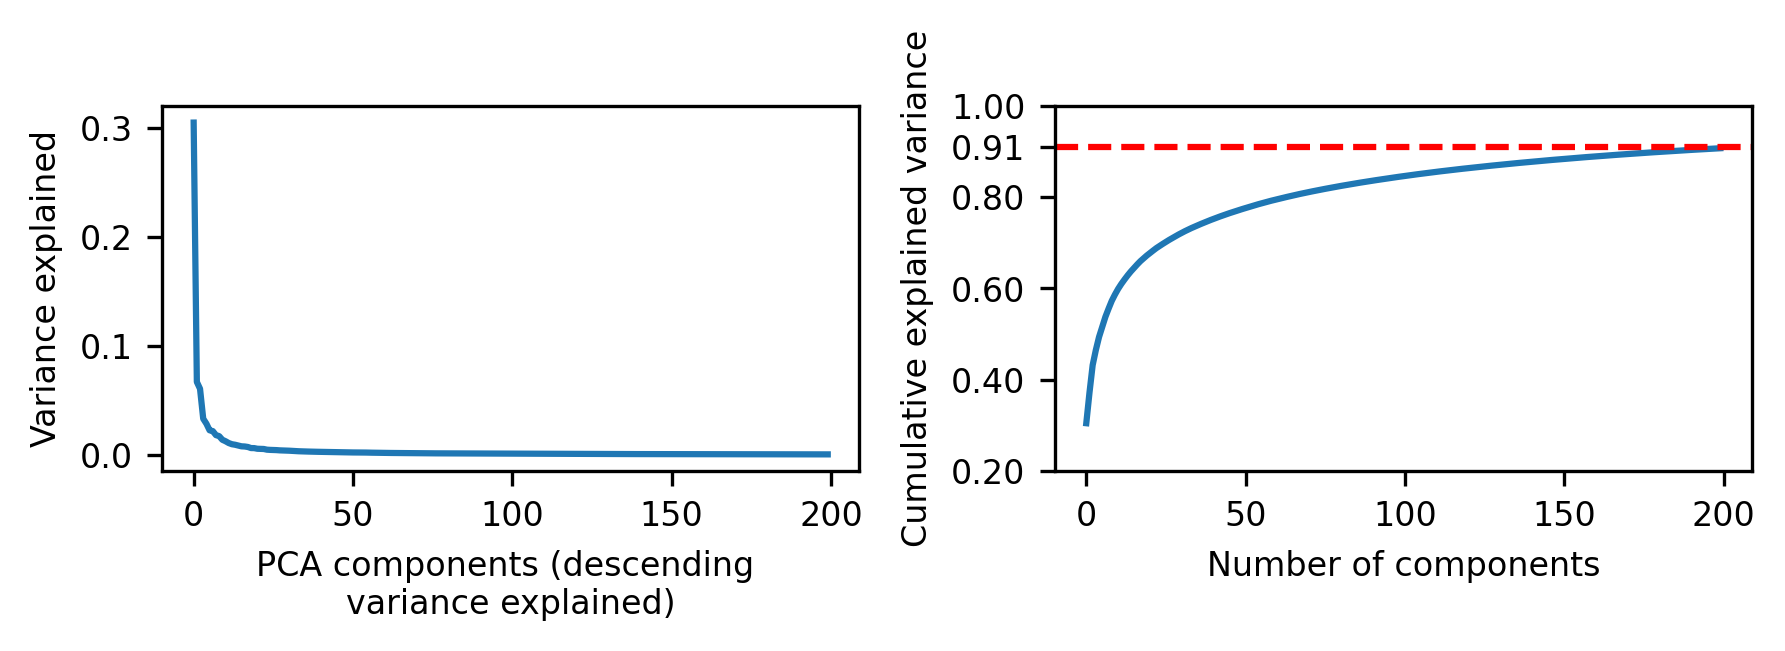

In [ ]:
plt.rcParams['font.size'] = '8'

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2))
ax1.plot(pca_transformer.explained_variance_ratio_)
ax1.set(xlabel='PCA components (descending \nvariance explained)', ylabel = 'Variance explained')

ax2.plot(np.cumsum(pca_transformer.explained_variance_ratio_))
ax2.set(xlabel='Number of components', ylabel='Cumulative explained variance')
plt.yticks(list(plt.yticks()[0]) + [0.91])
ax2.axhline(y=0.91, c='r', ls='--', label=r'$j=3$')

plt.gcf().set_dpi(300)
plt.tight_layout()
plt.show()

With just 200 Principal Components, around 91% of the variance of 1,000 randomly selected samples is explained. Next, we visualise the impact of dimensionality reduction on a few randomly selected images.

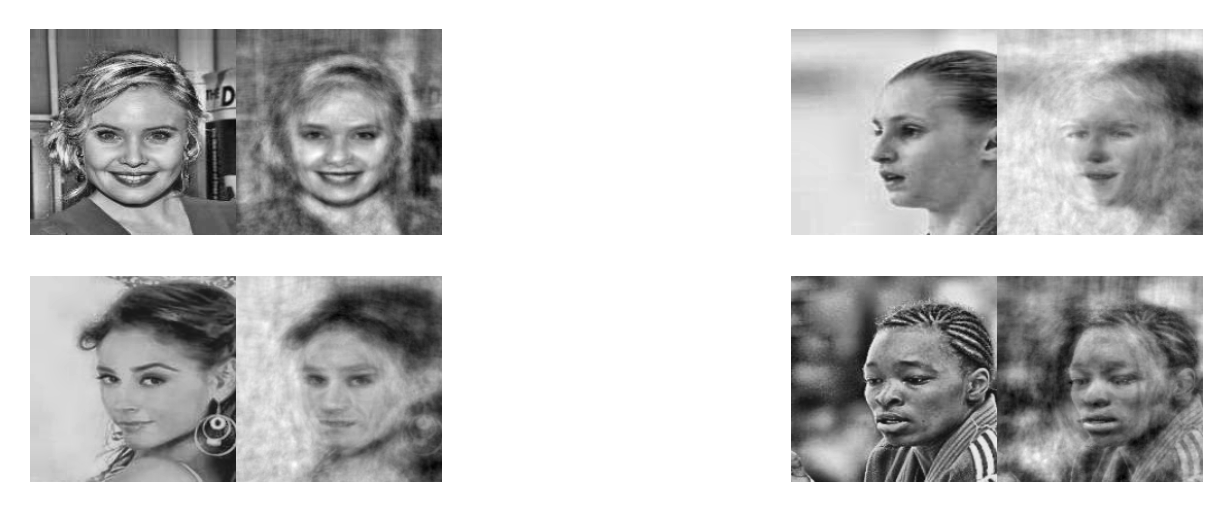

In [ ]:
# Visualise effect of PCA decomposition
np.random.seed(0)
randomsel = np.random.choice(len(pca_trainsample),4)

orig = pca_trainsample[randomsel]
toinv = pca_transformedsample[randomsel]

pca_inv = pca_transformer.inverse_transform(toinv)

plt.figure(figsize=(6,2))
plt.gcf().set_dpi(300)
for i in range(len(randomsel)):
    img_orig = np.reshape(orig[i,:],(imgsize,-1))
    img_inv = np.reshape(pca_inv[i,:],(imgsize,-1))
    plt.subplot(2,2,i+1)
    plt.imshow(np.hstack((img_orig,img_inv)), cmap='gray')
    plt.axis("off")
    

We noted that the dimensionality reduction procedure appears to retain mostly facial features. All images from the train and test sets are PCA transformed for use in training of the classification model.

In [ ]:
# batch process training data, reduce dimensions

def readimgreducedim(filepath, imgsize, transformer, enhance_contrast = True, convert_grayscale = True):
    img = readflattenedimg(filepath, imgsize, enhance_contrast, convert_grayscale)
    img = np.reshape(img, (1,-1))
    transformed = transformer.transform(img)
    return transformed

In [ ]:
# read in PCA transformed train and test sets
train = Parallel(n_jobs = -2)(delayed(readimgreducedim)(f, imgsize, pca_transformer) for f in tqdm(img_train))
train = np.vstack(train)

test = Parallel(n_jobs = -2)(delayed(readimgreducedim)(f, imgsize, pca_transformer) for f in tqdm(img_test))
test = np.vstack(test)

100%|███████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:26<00:00, 57.94it/s]


In [ ]:
import sys
print(f'Size of dimension reduced training dataset: {round(sys.getsizeof(train)/1000000,0)} Megabytes')
print(f'Size of dimension reduced test dataset: {round(sys.getsizeof(test)/1000000,0)} Megabytes')

Size of dimension reduced training dataset: 24.0 Megabytes
Size of dimension reduced test dataset: 8.0 Megabytes


The final memory requirement for storing the transformed training and test datasets are 24MB and 8MB respectively, a substantial reduction from the actual input size.

# Logistic Regression
We first performed a baseline logistic regression algorithm, utilising input images of size 200x200px, with 200 principal components and naive gradient descent. Then, we assess if alternative gradient descent algorithms are preferred over the naive approach. The model with the best performing gradient descent algorithm will be used for the subsequent experiments. At each step, we assess the performance of each model using accuracy of predictions on the test set.

In [ ]:
# setup logistic regression
def singleLoss(b, x, y):
    return jnp.log(1 + jnp.exp(-y * jnp.dot(b, x)))

def meanLoss(b, x, y):
    vmapLoss = jax.vmap(singleLoss, in_axes = (None, 0, 0))
    lossArray = vmapLoss(b, x, y)
    return jnp.mean(lossArray)

lossGrad = jax.jit(jax.value_and_grad(meanLoss, argnums = 0))

def predictOne(b, x):
    return 1 / (1 + jnp.exp(-1 * jnp.dot(b,x)))

def predictAll(b, x):
    vmapPred = jax.vmap(predictOne, in_axes = (None, 0))
    preds = vmapPred(b, x)
    return jnp.where(preds > 0.5, 1, -1)

def predictAllLogits(b, x):
    vmapPred = jax.vmap(predictOne, in_axes = (None, 0))
    preds = vmapPred(b, x)
    return preds

In [ ]:
# define some form of API for the gd functions returning newb, previousb
def naivegd(b, g, b_prev, t, lr):
    newb = b - lr * g 
    return newb, None
    
def momentumgd(b, g, b_prev, t, lr, momentum):
    b_prev_hold = b
    newb = b - lr * g + momentum * (b - b_prev)
    b_prev = b_prev_hold
    return newb, b_prev

def adamgd(b, g, b_prev, t, lr, alpha, b1, b2, esp):
    if not('mt' in locals()):  
        global mt
        mt = np.zeros(g.shape[0]) 
    if not('vt' in locals()):  
        global vt
        vt = np.zeros(g.shape[0])
    
    g2 = np.multiply(g,g)
    mt = b1 * mt + (1 - b1) * g
    vt = b2 * vt + (1 - b2) * g2
    m_hat = mt/(1 - b1 ** t)
    v_hat = vt/(1 - b2 ** t)
    newb = b - alpha * m_hat / (np.sqrt(v_hat) + esp)
    return newb, None

def lrdecay(b, g, b_prev, t, lr, lr_init, lr_lambda):
    lr = lr_init/(1 + (lr_lambda * t))
    newb = b - lr * g
    return newb, None

In [ ]:
def trainmodel(traindata, attrtrain, testdata, attrtest, lossGrad, gdfunction, batchsize = 128, epochs = 100, **kwargs):
    # tracking
    lossHistory = []
    test_acc = []
    train_acc = []
    lr_history = []

    # get data dimensions
    trainsize = traindata.shape[0]
    testsize = testdata.shape[0]
    dim = traindata.shape[1]

    # compute number of batches per epoch
    n_trainbatches = int(trainsize/batchsize) + 1
    n_testbatches = int(testsize/batchsize) + 1

    # generate indices for SGD
    trainIndices = np.arange(trainsize)
    testIndices = np.arange(testsize)
    
    # initialize betas
    b = np.random.normal(0, 1/np.sqrt(dim), size = dim)
    
    t = 0

    b_prev = b
    attrtrain = np.array(attrtrain)
    
    for epoch in range(epochs):
        np.random.shuffle(trainIndices)

        for i in range(n_trainbatches):
            
            t += 1    
            batchStart = i * batchsize
            batchEnd = (i + 1) * batchsize
            if batchEnd < trainsize:
                idxs = trainIndices[batchStart:batchEnd,]
            else:
                idxs = trainIndices[batchStart:,]

            traindata_batch = traindata[idxs]

            y_train = attrtrain[idxs]

            v, g = lossGrad(b, traindata_batch, y_train)
           
            b, b_prev = gdfunction(b, g, b_prev, t, **kwargs)

            lossHistory.append(v)
            
        # for test data set
        epochpreds_test = predictAll(b, testdata)
        epochpreds_test = np.array(epochpreds_test)
        test_accuracy_epoch = np.mean(epochpreds_test == attrtest)
        test_acc.append(test_accuracy_epoch)
        
        # for train data set
        epochpreds_train = predictAll(b, traindata)
        epochpreds_train = np.array(epochpreds_train)
        train_accuracy_epoch = np.mean(epochpreds_train == attrtrain)
        train_acc.append(train_accuracy_epoch)
        
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Train Accuracy: {train_accuracy_epoch:.3f} | Test Accuracy: {test_accuracy_epoch:.3f}')
        elif epoch == epochs - 1:
            print(f'Final Epoch, Train Accuracy: {train_accuracy_epoch:.3f} | Test Accuracy: {test_accuracy_epoch:.3f}')
        
    return train_acc, test_acc, lr_history, lossHistory, b

In [ ]:
print('Training model with Naive GD')
naive_train_acc, naive_test_acc, naive_lr, naive_loss, naive_weights = \
trainmodel(train, attr_train, test, attr_test, lossGrad, naivegd, batchsize = 128, \
           epochs = 500, lr = 0.01)

print('\nTraining model with GD with Momentum')
mom_train_acc, mom_test_acc, mom_lr, mom_loss, mom_weights = \
trainmodel(train, attr_train, test, attr_test, lossGrad, momentumgd, batchsize = 128, \
           epochs = 500, lr = 0.001, momentum = 0.8)

print('\nTraining model with GD with Decay')
decay_train_acc, decay_test_acc, decay_lr, decay_loss, decay_weights = \
trainmodel(train, attr_train, test, attr_test, lossGrad, lrdecay, batchsize = 128, \
           epochs = 500,lr = 0.01, lr_init = 0.01, lr_lambda = 0.001)

print('\nTraining model with Adam GD')
adam_train_acc, adam_test_acc, adam_lr, adam_loss, adam_weights = \
trainmodel(train, attr_train, test, attr_test, lossGrad, adamgd, batchsize = 128, \
           epochs = 500, lr = 0.001, alpha = 0.001,b1 = 0.9, b2 = 0.999, esp = 10e-8)

Training model with Naive GD
Epoch: 0, Train Accuracy: 0.806 | Test Accuracy: 0.810
Epoch: 100, Train Accuracy: 0.876 | Test Accuracy: 0.878
Epoch: 200, Train Accuracy: 0.877 | Test Accuracy: 0.880
Epoch: 300, Train Accuracy: 0.873 | Test Accuracy: 0.874
Epoch: 400, Train Accuracy: 0.871 | Test Accuracy: 0.867
Final Epoch, Train Accuracy: 0.869 | Test Accuracy: 0.874

Training model with GD with Momentum
Epoch: 0, Train Accuracy: 0.729 | Test Accuracy: 0.732
Epoch: 100, Train Accuracy: 0.877 | Test Accuracy: 0.878
Epoch: 200, Train Accuracy: 0.878 | Test Accuracy: 0.878
Epoch: 300, Train Accuracy: 0.878 | Test Accuracy: 0.878
Epoch: 400, Train Accuracy: 0.878 | Test Accuracy: 0.880
Final Epoch, Train Accuracy: 0.878 | Test Accuracy: 0.880

Training model with GD with Decay
Epoch: 0, Train Accuracy: 0.790 | Test Accuracy: 0.805
Epoch: 100, Train Accuracy: 0.878 | Test Accuracy: 0.879
Epoch: 200, Train Accuracy: 0.879 | Test Accuracy: 0.879
Epoch: 300, Train Accuracy: 0.879 | Test Accura

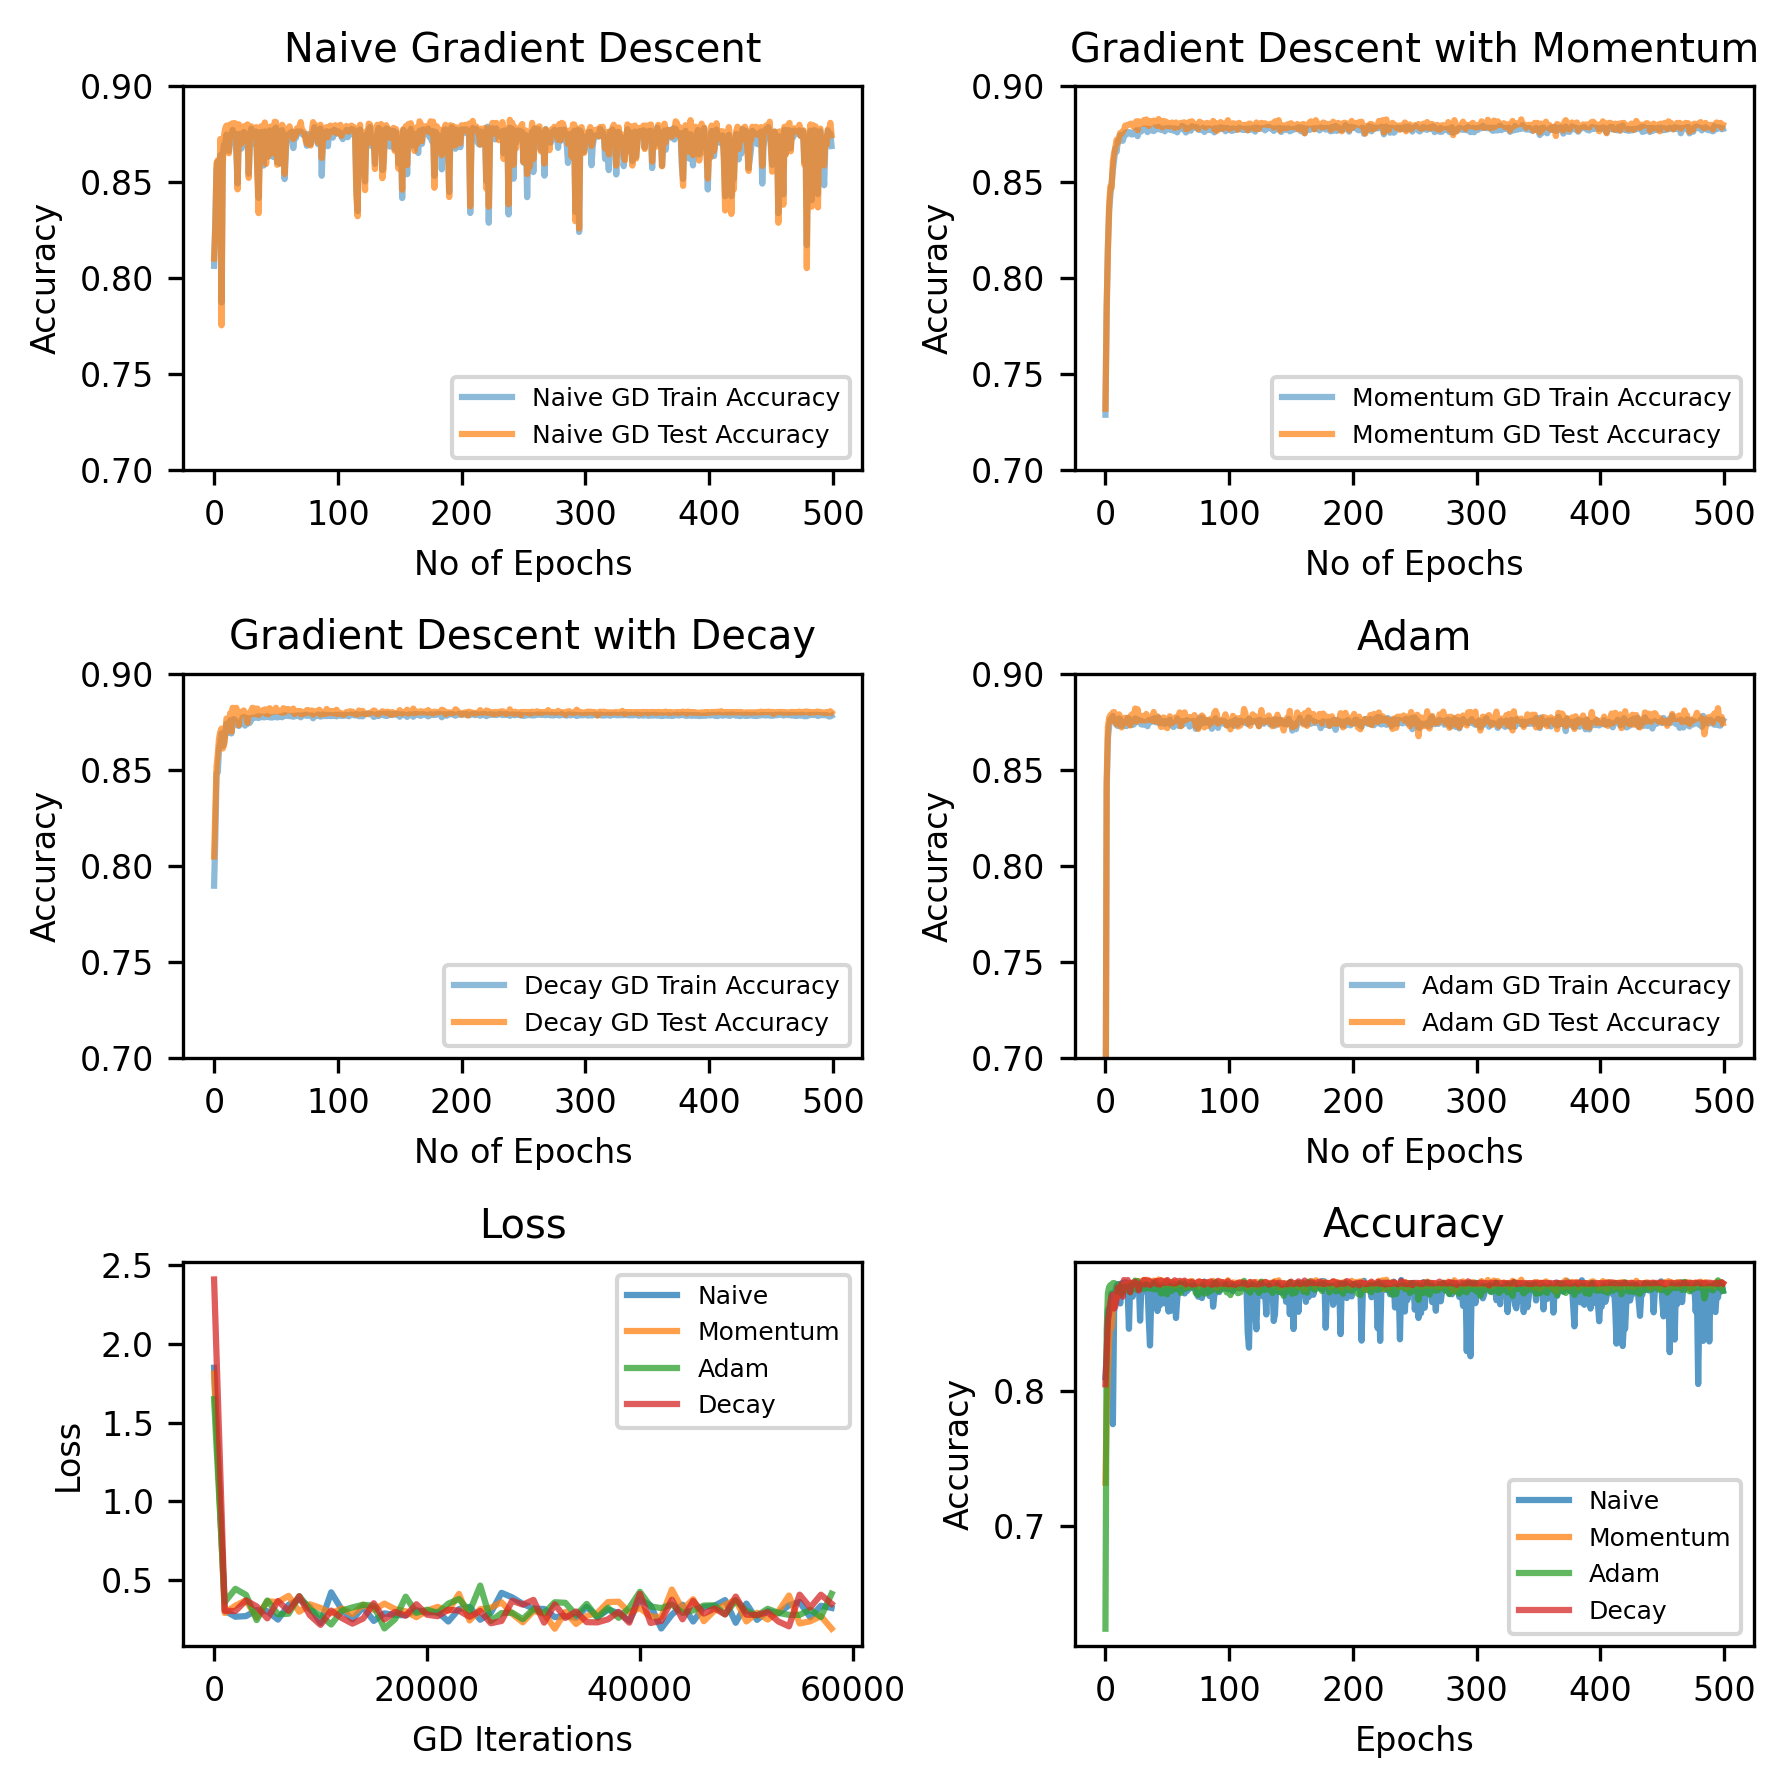

In [ ]:
plt.rcParams['font.size'] = '8'
fig, ax = plt.subplots(3,2, figsize = (6,6))
iters = range(len(naive_loss))

ax[0,0].plot(naive_train_acc, alpha=0.5)
ax[0,0].plot(naive_test_acc, alpha=0.7)
ax[0,0].set(title='Naive Gradient Descent', ylabel='Accuracy', xlabel='No of Epochs', ylim = (0.7,0.9))
ax[0,0].legend(['Naive GD Train Accuracy', 'Naive GD Test Accuracy'], prop={'size': 6}, loc = 4)

ax[0,1].plot(mom_train_acc, alpha=0.5)
ax[0,1].plot(mom_test_acc, alpha=0.7)
ax[0,1].set(title='Gradient Descent with Momentum', ylabel='Accuracy', xlabel='No of Epochs', ylim = (0.7,0.9))
ax[0,1].legend(['Momentum GD Train Accuracy', 'Momentum GD Test Accuracy'], prop={'size': 6}, loc = 4)

ax[1,0].plot(decay_train_acc, alpha=0.5)
ax[1,0].plot(decay_test_acc, alpha=0.7)
ax[1,0].set(title='Gradient Descent with Decay', ylabel='Accuracy', xlabel='No of Epochs', ylim = (0.7,0.9))
ax[1,0].legend(['Decay GD Train Accuracy', 'Decay GD Test Accuracy'], prop={'size': 6}, loc = 4)

ax[1,1].plot(adam_train_acc, alpha=0.5)
ax[1,1].plot(adam_test_acc, alpha=0.7)
ax[1,1].set(title='Adam', ylabel='Accuracy', xlabel='No of Epochs', ylim = (0.7,0.9))
ax[1,1].legend(['Adam GD Train Accuracy', 'Adam GD Test Accuracy'], prop={'size': 6}, loc = 4)

ax[2,0].plot(iters[::1000], naive_loss[::1000], label = 'Naive', alpha = 0.75)
ax[2,0].plot(iters[::1000], mom_loss[::1000], label = 'Momentum', alpha = 0.75)
ax[2,0].plot(iters[::1000], adam_loss[::1000], label = 'Adam', alpha = 0.75)
ax[2,0].plot(iters[::1000], decay_loss[::1000], label = 'Decay', alpha = 0.75)
ax[2,0].set(xlabel='GD Iterations', ylabel='Loss', title='Loss')
ax[2,0].legend(prop={'size': 6}, loc = 1)

ax[2,1].plot(naive_test_acc, label = 'Naive', alpha = 0.75)
ax[2,1].plot(mom_test_acc, label = 'Momentum', alpha = 0.75)
ax[2,1].plot(adam_test_acc, label = 'Adam', alpha = 0.75)
ax[2,1].plot(decay_test_acc, label = 'Decay', alpha = 0.75)
ax[2,1].set(xlabel='Epochs', ylabel='Accuracy', title = 'Accuracy')
ax[2,1].legend(prop={'size': 6}, loc = 4)

plt.gcf().set_dpi(300)
plt.tight_layout()
plt.show()

We noted that from the above graphs that all four types of gradient descent algorithms proved to have similar generalization abilities for the unseen test dataset at about 88.0% accuracy.

Comparing between train and test accuracies for each algorithm, we noted that is little overfitting of the logistic regression models. One possible explanation for this great generalization capability is perhaps that the dimensional reduction process  produced a robust representation of face images, and therefore produced similar outputs for both the training and the (unseen) test data.

Another key observation to note is that the Naive GD algorithm has a larger variation in accuracy as compared to the rest.

Also, all 4 algorithms appear to reach convergece well within 100 epochs and the Adam algorithm converges the fastest.

Given the similar accuracy of all 4 GD algorithms for this task, we select and present the results on the test set for the model fitted using **Gradient Descent with Momentum** as it performed similarly but remains parsimonious.

The ROC Curve and AUC of 0.95 is presented below.

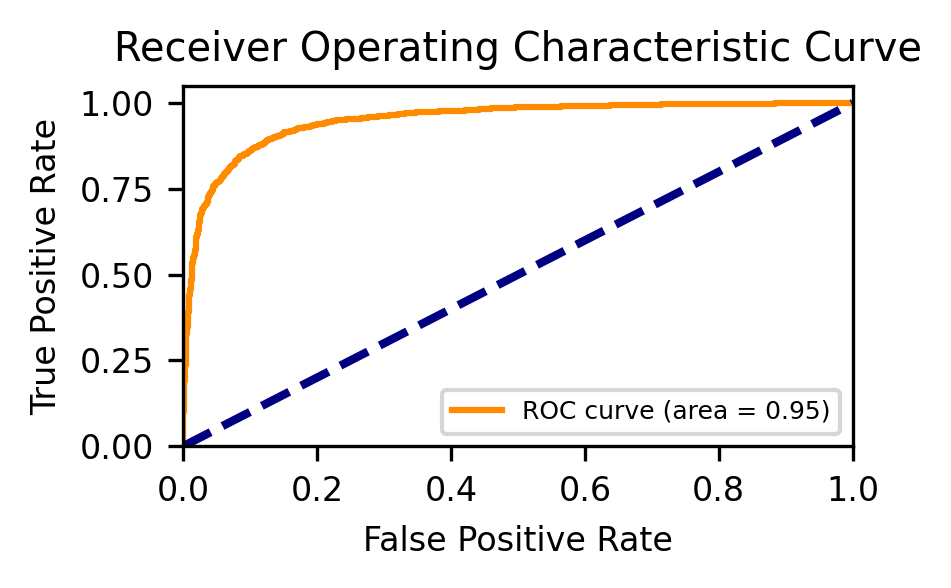

In [ ]:
# Plot Receiving Operating Characteristic 
pred_logits = predictAllLogits(mom_weights, test)
fpr, tpr, thresh = roc_curve(attr_test, pred_logits)
auc = roc_auc_score(attr_test, pred_logits)

plt.figure(figsize=(3,2))
plt.rcParams['font.size'] = '8'
plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {round(auc,2)})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right", prop={'size': 6})
plt.gcf().set_dpi(300)
plt.tight_layout()
plt.show()

# Additional Tasks for DSA4212 Assignment 1
Next, we address the following questions that are part of Assignment 1:

1. how does the accuracy of the prediction change with the size of the training set?
2. how does the accuracy of the prediction change with resolution of the input images?
3. compare the performance of the model using colored vs grayscale images
4. compare the performance of the models using various parts of the faces
5. compare ensemble models
6. Report the error rate and AUC of your best model (when evaluated on the last 5,000 images)
7. identify a model with good performance if the data input is limited to first 200 images

## Question 1
**How does the accuracy (ie. tested on the last 5,000 images) depend on the size of the training set? Is it necessary to use all the training set, or does the accuracy stabilize before?**

To address this question we compare model performance when the training set size is reduced from 15,000 to 500, 1,000, 5,000 and 10,000 by randomly selecting the required number of images for training, then assessing performance on the 5,000 images test set.

In [ ]:
idx_range = np.arange(len(train))

# generate indices
idx_500 = np.random.choice(idx_range, size=500, replace=False)
idx_1000 = np.random.choice(idx_range, size=1000, replace=False)
idx_5000 = np.random.choice(idx_range, size=5000, replace=False)
idx_10000 = np.random.choice(idx_range, size=10000, replace=False)

print('Training model with 500 image inputs')
mom_train_500, mom_test_500, mom_lr_500, mom_loss_500, mom_weights_500 = \
trainmodel(train[idx_500], attr_train[idx_500], test, attr_test, lossGrad, momentumgd, batchsize = 128, epochs = 300,
                                                    lr = 0.001, momentum = 0.8)
print('\nTraining model with 1000 image inputs')
mom_train_1000, mom_test_1000, mom_lr_1000, mom_loss_1000, mom_weights_1000 = \
trainmodel(train[idx_1000], attr_train[idx_1000], test, attr_test, lossGrad, momentumgd, batchsize = 128, epochs = 300,
                                                    lr = 0.001, momentum = 0.8)
print('\nTraining model with 5000 image inputs')
mom_train_5000, mom_test_5000, mom_lr_5000, mom_loss_5000, mom_weights_5000 = \
trainmodel(train[idx_5000], attr_train[idx_5000], test, attr_test, lossGrad, momentumgd, batchsize = 128, epochs = 300,
                                                    lr = 0.001, momentum = 0.8)
print('\nTraining model with 10000 image inputs')
mom_train_10000, mom_test_10000, mom_lr_10000, mom_loss_10000, mom_weights_10000 = \
trainmodel(train[idx_10000], attr_train[idx_10000], test, attr_test, lossGrad, momentumgd, batchsize = 128, epochs = 300,
                                                    lr = 0.001, momentum = 0.8)

Training model with 500 image inputs
Epoch: 0, Train Accuracy: 0.604 | Test Accuracy: 0.567
Epoch: 100, Train Accuracy: 0.880 | Test Accuracy: 0.773
Epoch: 200, Train Accuracy: 0.916 | Test Accuracy: 0.782
Final Epoch, Train Accuracy: 0.932 | Test Accuracy: 0.786

Training model with 1000 image inputs
Epoch: 0, Train Accuracy: 0.474 | Test Accuracy: 0.457
Epoch: 100, Train Accuracy: 0.896 | Test Accuracy: 0.817
Epoch: 200, Train Accuracy: 0.922 | Test Accuracy: 0.830
Final Epoch, Train Accuracy: 0.926 | Test Accuracy: 0.827

Training model with 5000 image inputs
Epoch: 0, Train Accuracy: 0.678 | Test Accuracy: 0.673
Epoch: 100, Train Accuracy: 0.886 | Test Accuracy: 0.870
Epoch: 200, Train Accuracy: 0.889 | Test Accuracy: 0.866
Final Epoch, Train Accuracy: 0.889 | Test Accuracy: 0.865

Training model with 10000 image inputs
Epoch: 0, Train Accuracy: 0.688 | Test Accuracy: 0.679
Epoch: 100, Train Accuracy: 0.875 | Test Accuracy: 0.876
Epoch: 200, Train Accuracy: 0.875 | Test Accuracy: 0

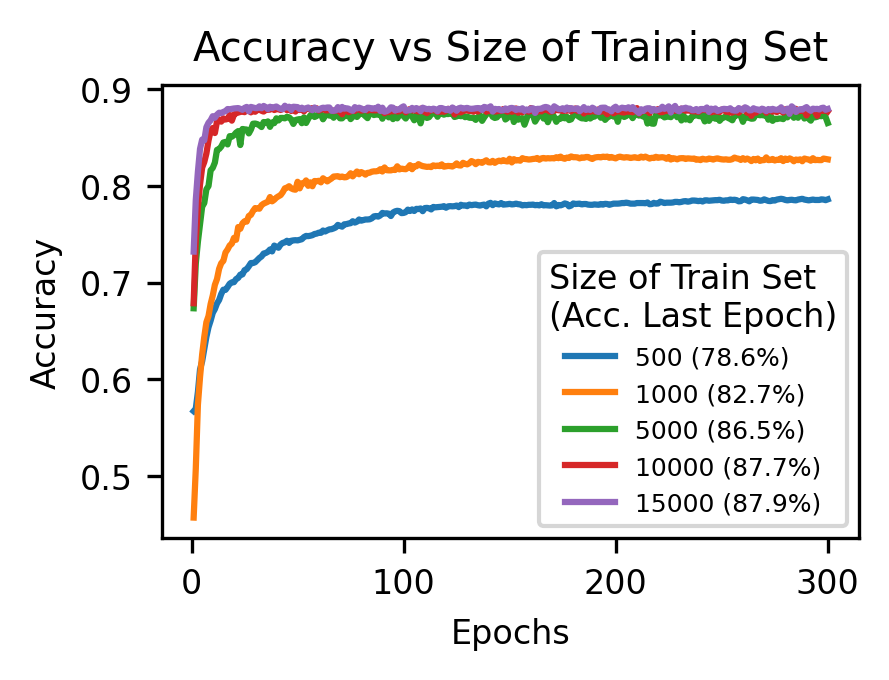

In [ ]:
plt.figure(figsize=(3,2))
plt.rcParams['font.size'] = '8'
plt.gcf().set_dpi(300)

plt.plot(np.arange(300)+1,mom_test_500, label=f'500 ({np.round(mom_test_500[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_1000, label=f'1000 ({np.round(mom_test_1000[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_5000, label=f'5000 ({np.round(mom_test_5000[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_10000, label=f'10000 ({np.round(mom_test_10000[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc[:300], label=f'15000 ({np.round(mom_test_acc[299]*100,1)}%)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Size of Training Set')
plt.legend(title='Size of Train Set\n(Acc. Last Epoch)', prop={'size':6})
plt.show()

Comparing the accuracy of each model at convergence, we noted that the accuracy of the trained model predicting on the test set increases with the size of the training set provided. A model fitted using just 5,000 training samples has nearly the same performance as the model fitted using 15,000 samples.

## Question 2
**How does the accuracy depend on the resolution of the input image?**

To understand the impact of reducing/increasing input image size, we modified the size of input images and assessed the performance of the fitted models at the following input sizes:  

1. 50 x 50
1. 100 x 100
1. 150 x 150

The performance of these 3 models are then compared to the baseline model (Logistic Regression fitted with GD with momentum and 200x200px input).

In [ ]:
# create a function to generate datasets of different dimentions
def gendatasets(img_train, img_test, imgsize, n_components, enhance_contrast = True, convert_grayscale = True, n_samples=1000):
   
    print(f'Fitting PCA {imgsize}px {n_components} PCA Components')
    pca_trainsample = genpcadataset(imgsize, img_train, n_samples, enhance_contrast, convert_grayscale)
    pca_transformer = performpca(pca_trainsample, n_components)
    
    print(f'Generating Train Set {imgsize}px {n_components} PCA Components')
    train = Parallel(n_jobs = -2)(delayed(readimgreducedim)(f, imgsize, pca_transformer, enhance_contrast, convert_grayscale) for f in img_train)
    train = np.vstack(train)
    
    print(f'Generating Test Set {imgsize}px {n_components} PCA Components')
    test = Parallel(n_jobs = -2)(delayed(readimgreducedim)(f, imgsize, pca_transformer, enhance_contrast, convert_grayscale) for f in img_test)
    test = np.vstack(test)
    
    return train, test

In [ ]:
# generate datasets with different picture sizes, but PCA is still using 200 components
train_25x25, test_25x25 = gendatasets(img_train, img_test, imgsize = 25, n_components = 200)
train_50x50, test_50x50 = gendatasets(img_train, img_test, imgsize = 50, n_components = 200)
train_100x100, test_100x100 = gendatasets(img_train, img_test, imgsize = 100, n_components = 200)
train_150x150, test_150x150 = gendatasets(img_train, img_test, imgsize = 150, n_components = 200)

Fitting PCA 25px 200 PCA Components
Generating Train Set 25px 200 PCA Components
Generating Test Set 25px 200 PCA Components
Fitting PCA 50px 200 PCA Components
Generating Train Set 50px 200 PCA Components
Generating Test Set 50px 200 PCA Components
Fitting PCA 100px 200 PCA Components
Generating Train Set 100px 200 PCA Components
Generating Test Set 100px 200 PCA Components
Fitting PCA 150px 200 PCA Components
Generating Train Set 150px 200 PCA Components
Generating Test Set 150px 200 PCA Components


In [ ]:
# train new models with different dimension inputs.
# 25x25px input
print('Fitting 25x25px model')
mom_train_acc_25px, mom_test_acc_25px, mom_lr_25px, mom_loss_25px, mom_weights_25px = \
trainmodel(train_25x25, attr_train, test_25x25, attr_test, lossGrad, momentumgd, batchsize = 128, \
           epochs = 300, lr = 0.001, momentum = 0.8)
# 50x50px input
print('Fitting 50x50px model')
mom_train_acc_50px, mom_test_acc_50px, mom_lr_50px, mom_loss_50px, mom_weights_50px = \
trainmodel(train_50x50, attr_train, test_50x50, attr_test, lossGrad, momentumgd, batchsize = 128, \
           epochs = 300, lr = 0.001, momentum = 0.8)
# 50x50px input
print('\nFitting 100x100px model')
mom_train_acc_100px, mom_test_acc_100px, mom_lr_100px, mom_loss_100px, mom_weights_100px = \
trainmodel(train_100x100, attr_train, test_100x100, attr_test, lossGrad, momentumgd, batchsize = 128, \
           epochs = 300, lr = 0.001, momentum = 0.8)
# 150x150px input
print('\nFitting 150x150px model')
mom_train_acc_150px, mom_test_acc_150px, mom_lr_150px, mom_loss_150px, mom_weights_150px = \
trainmodel(train_150x150, attr_train, test_150x150, attr_test, lossGrad, momentumgd, batchsize = 128, \
           epochs = 300, lr = 0.001, momentum = 0.8)

Fitting 25x25px model
Epoch: 0, Train Accuracy: 0.536 | Test Accuracy: 0.546
Epoch: 100, Train Accuracy: 0.799 | Test Accuracy: 0.802
Epoch: 200, Train Accuracy: 0.814 | Test Accuracy: 0.812
Final Epoch, Train Accuracy: 0.818 | Test Accuracy: 0.819
Fitting 50x50px model
Epoch: 0, Train Accuracy: 0.601 | Test Accuracy: 0.610
Epoch: 100, Train Accuracy: 0.849 | Test Accuracy: 0.856
Epoch: 200, Train Accuracy: 0.854 | Test Accuracy: 0.859
Final Epoch, Train Accuracy: 0.857 | Test Accuracy: 0.858

Fitting 100x100px model
Epoch: 0, Train Accuracy: 0.663 | Test Accuracy: 0.665
Epoch: 100, Train Accuracy: 0.875 | Test Accuracy: 0.878
Epoch: 200, Train Accuracy: 0.878 | Test Accuracy: 0.880
Final Epoch, Train Accuracy: 0.876 | Test Accuracy: 0.879

Fitting 150x150px model
Epoch: 0, Train Accuracy: 0.722 | Test Accuracy: 0.721
Epoch: 100, Train Accuracy: 0.878 | Test Accuracy: 0.881
Epoch: 200, Train Accuracy: 0.878 | Test Accuracy: 0.882
Final Epoch, Train Accuracy: 0.878 | Test Accuracy: 0.88

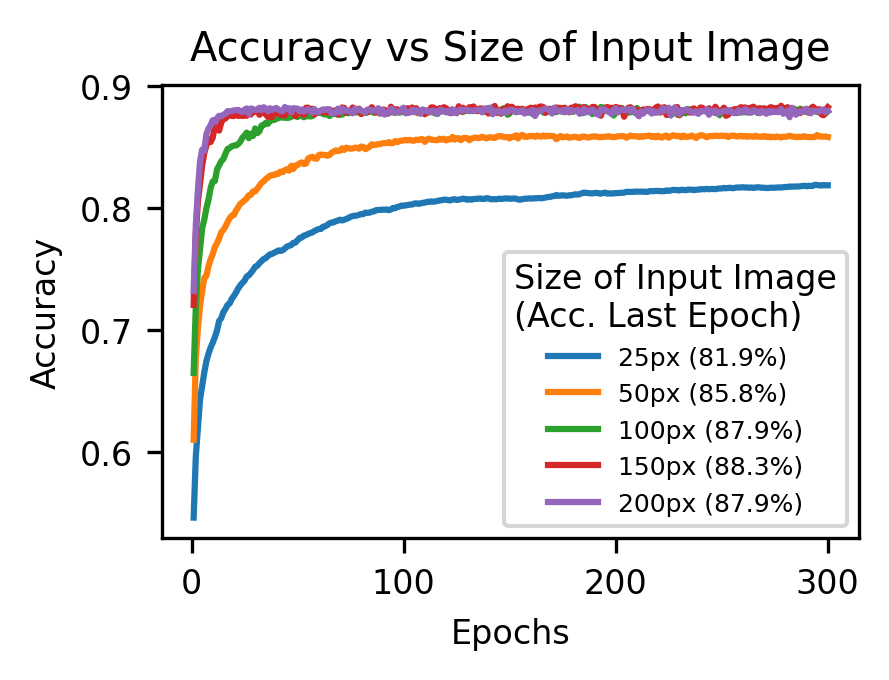

In [ ]:
plt.figure(figsize=(3,2))
plt.rcParams['font.size'] = '8'
plt.gcf().set_dpi(300)

plt.plot(np.arange(300)+1,mom_test_acc_25px, label=f'25px ({np.round(mom_test_acc_25px[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc_50px, label=f'50px ({np.round(mom_test_acc_50px[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc_100px, label=f'100px ({np.round(mom_test_acc_100px[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc_150px, label=f'150px ({np.round(mom_test_acc_150px[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc[:300], label=f'200px ({np.round(mom_test_acc[299]*100,1)}%)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Size of Input Image')
plt.legend(title='Size of Input Image\n(Acc. Last Epoch)', prop = {'size':6})
plt.show()

We observed significantly lower test set accuracy with smaller input images. This is expected, as in the process of scaling down the images, we are discarding image details that could be used by the model for classification. 

The test set accuracy increases as in the input image size increases. Further, we note that a model fitted with 100x100px image as input has similar performance as a model fitted with 200x200px inputs.

## Question 3
**Is it necessary to use colored images (or black & white images are enough)? Is it helpful to increase the contrast of the images? Other preprocessing ideas?**

### Adjusting Number of PCA Components
The performance of our models may be limited by the arbitrarily chosen 200 PCA components. Setting the baseline as the 150x150px model (since it performs similarly to the 200x200px model), we compare the performance of models fitted with different number of PCA components.

In [ ]:
train_150x150_100, test_150x150_100 = gendatasets(img_train, img_test, imgsize = 150, n_components = 100)
train_150x150_500, test_150x150_500 = gendatasets(img_train, img_test, imgsize = 150, n_components = 500)
train_150x150_1000, test_150x150_1000 = gendatasets(img_train, img_test, imgsize = 150, n_components = 1000)

Fitting PCA 150px 100 PCA Components
Generating Train Set 150px 100 PCA Components
Generating Test Set 150px 100 PCA Components
Fitting PCA 150px 500 PCA Components
Generating Train Set 150px 500 PCA Components
Generating Test Set 150px 500 PCA Components
Fitting PCA 150px 1000 PCA Components
Generating Train Set 150px 1000 PCA Components
Generating Test Set 150px 1000 PCA Components


In [ ]:
print('\nFitting 150x150px model with 100 components')
mom_train_acc_150px_100, mom_test_acc_150px_100, mom_lr_150px_100, mom_loss_150px_100, mom_weights_150px_100 = \
trainmodel(train_150x150_100, attr_train, test_150x150_100, attr_test, lossGrad, momentumgd, batchsize = 128, \
           epochs = 300, lr = 0.001, momentum = 0.8)

print('\nFitting 150x150px model with 500 components')
mom_train_acc_150px_500, mom_test_acc_150px_500, mom_lr_150px_500, mom_loss_150px_500, mom_weights_150px_500 = \
trainmodel(train_150x150_500, attr_train, test_150x150_500, attr_test, lossGrad, momentumgd, batchsize = 128, \
           epochs = 300, lr = 0.001, momentum = 0.8)

print('\nFitting 150x150px model with 1000 components')
mom_train_acc_150px_1000, mom_test_acc_150px_1000, mom_lr_150px_1000, mom_loss_150px_1000, mom_weights_150px_1000 = \
trainmodel(train_150x150_1000, attr_train, test_150x150_1000, attr_test, lossGrad, momentumgd, batchsize = 128, \
           epochs = 300, lr = 0.001, momentum = 0.8)


Fitting 150x150px model with 100 components
Epoch: 0, Train Accuracy: 0.706 | Test Accuracy: 0.704
Epoch: 100, Train Accuracy: 0.817 | Test Accuracy: 0.818
Epoch: 200, Train Accuracy: 0.818 | Test Accuracy: 0.820
Final Epoch, Train Accuracy: 0.818 | Test Accuracy: 0.819

Fitting 150x150px model with 500 components
Epoch: 0, Train Accuracy: 0.736 | Test Accuracy: 0.738
Epoch: 100, Train Accuracy: 0.904 | Test Accuracy: 0.899
Epoch: 200, Train Accuracy: 0.907 | Test Accuracy: 0.900
Final Epoch, Train Accuracy: 0.907 | Test Accuracy: 0.897

Fitting 150x150px model with 1000 components
Epoch: 0, Train Accuracy: 0.761 | Test Accuracy: 0.760
Epoch: 100, Train Accuracy: 0.912 | Test Accuracy: 0.905
Epoch: 200, Train Accuracy: 0.916 | Test Accuracy: 0.906
Final Epoch, Train Accuracy: 0.917 | Test Accuracy: 0.905


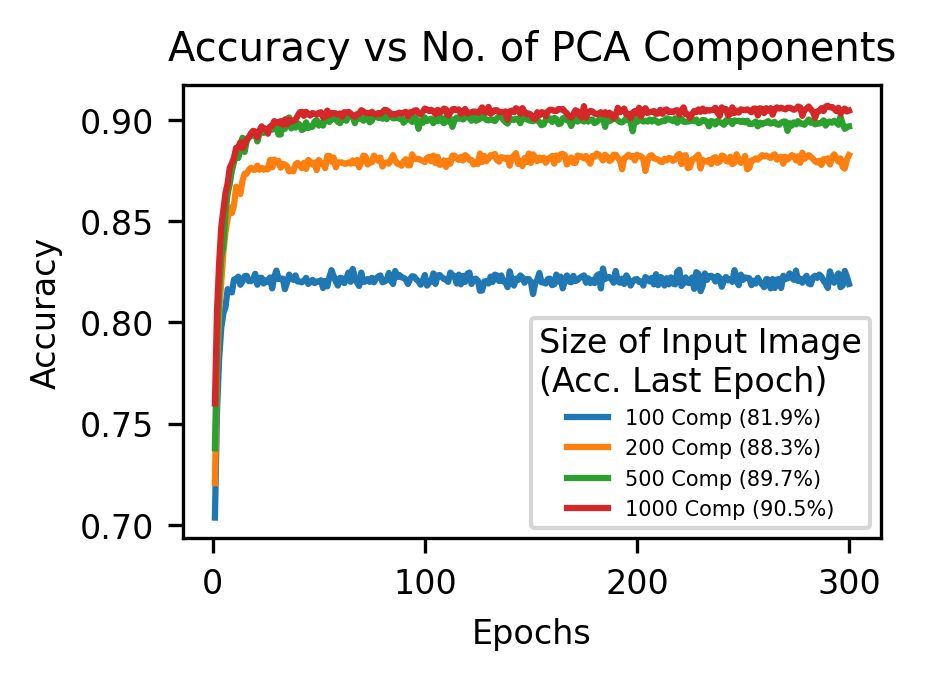

In [ ]:
plt.figure(figsize=(3,2))
plt.rcParams['font.size'] = '8'
plt.gcf().set_dpi(300)
plt.plot(np.arange(300)+1,mom_test_acc_150px_100, label=f'100 Comp ({np.round(mom_test_acc_150px_100[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc_150px, label=f'200 Comp ({np.round(mom_test_acc_150px[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc_150px_500, label=f'500 Comp ({np.round(mom_test_acc_150px_500[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc_150px_1000, label=f'1000 Comp ({np.round(mom_test_acc_150px_1000[-1]*100,1)}%)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs No. of PCA Components')
plt.legend(title='Size of Input Image\n(Acc. Last Epoch)', prop = {'size':5}, loc = 4)
plt.show()

As expected, the accuracy of predictions on the test set increases as the number of PCA components in the model increases since more variations in the input data is retained for training. The model with 1,000 PCA components performed the best with almost 91% accuracy on the test set.

In [ ]:
print(f'Size of train set with 100 PCA components: {round(sys.getsizeof(train_150x150_100)/1000000,0)} Megabytes')
print(f'Size of train set with 200 PCA components: {round(sys.getsizeof(train_150x150)/1000000,0)} Megabytes')
print(f'Size of train set with 500 PCA components: {round(sys.getsizeof(train_150x150_500)/1000000,0)} Megabytes')
print(f'Size of train set with 1,000 PCA components: {round(sys.getsizeof(train_150x150_1000)/1000000,0)} Megabytes')

Size of train set with 100 PCA components: 12.0 Megabytes
Size of train set with 200 PCA components: 24.0 Megabytes
Size of train set with 500 PCA components: 60.0 Megabytes
Size of train set with 1,000 PCA components: 120.0 Megabytes


### Utilising Colour Images
Next, we attempt to fit models utilising colour images as input.

In [ ]:
train_150x150_c2, test_150x150_c2 = gendatasets(img_train, img_test, imgsize = 150, n_components = 200, \
                                              enhance_contrast = True, convert_grayscale = False)
train_150x150_c6, test_150x150_c6 = gendatasets(img_train, img_test, imgsize = 150, n_components = 600, \
                                              enhance_contrast = True, convert_grayscale = False)

Fitting PCA 150px 200 PCA Components
Generating Train Set 150px 200 PCA Components
Generating Test Set 150px 200 PCA Components
Fitting PCA 150px 600 PCA Components
Generating Train Set 150px 600 PCA Components
Generating Test Set 150px 600 PCA Components


In [ ]:
print('\nFitting 150x150px model with 200 components and colour image input')
mom_train_acc_150px_c2, mom_test_acc_150px_c2, mom_lr_150px_c2, mom_loss_150px_c2, mom_weights_150px_c2 = \
trainmodel(train_150x150_c2, attr_train, test_150x150_c2, attr_test, lossGrad, momentumgd, batchsize = 128, \
           epochs = 300, lr = 0.001, momentum = 0.8)

print('\nFitting 150x150px model with 200 components and colour image input')
mom_train_acc_150px_c6, mom_test_acc_150px_c6, mom_lr_150px_c6, mom_loss_150px_c6, mom_weights_150px_c6 = \
trainmodel(train_150x150_c6, attr_train, test_150x150_c6, attr_test, lossGrad, momentumgd, batchsize = 128, \
           epochs = 300, lr = 0.001, momentum = 0.8)


Fitting 150x150px model with 200 components and colour image input
Epoch: 0, Train Accuracy: 0.798 | Test Accuracy: 0.803
Epoch: 100, Train Accuracy: 0.888 | Test Accuracy: 0.889
Epoch: 200, Train Accuracy: 0.889 | Test Accuracy: 0.889
Final Epoch, Train Accuracy: 0.880 | Test Accuracy: 0.883

Fitting 150x150px model with 200 components and colour image input
Epoch: 0, Train Accuracy: 0.809 | Test Accuracy: 0.819
Epoch: 100, Train Accuracy: 0.922 | Test Accuracy: 0.912
Epoch: 200, Train Accuracy: 0.921 | Test Accuracy: 0.911
Final Epoch, Train Accuracy: 0.921 | Test Accuracy: 0.911


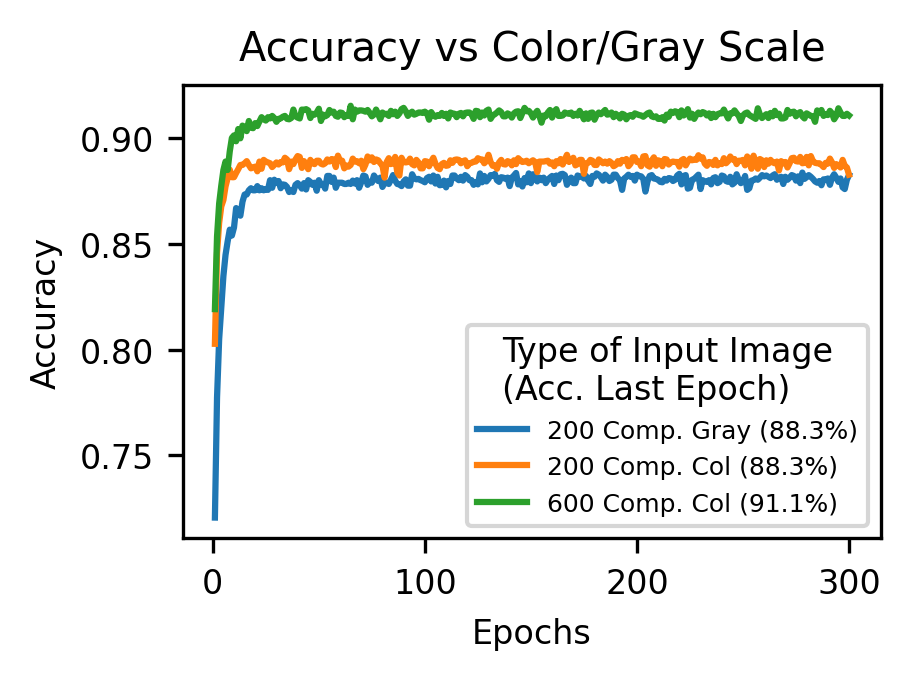

In [ ]:
plt.figure(figsize=(3,2))
plt.rcParams['font.size'] = '8'
plt.gcf().set_dpi(300)

plt.plot(np.arange(300)+1,mom_test_acc_150px, label=f'200 Comp. Gray ({np.round(mom_test_acc_150px[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc_150px_c2, label=f'200 Comp. Col ({np.round(mom_test_acc_150px_c2[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc_150px_c6, label=f'600 Comp. Col ({np.round(mom_test_acc_150px_c6[-1]*100,1)}%)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Color/Gray Scale')
plt.legend(title='Type of Input Image\n(Acc. Last Epoch)', prop = {'size':6})
plt.show()

We noted a slight improvement in test accuracy when color images are utilised as inputs. The model fitted with 150x150px colour images, with 600 PCA components performed the best among all models tested thus far.

## Question 4
**What if one only uses the area around the eyes? Around the mouth? The hair? The ears? Etc..**

We attempt to predict the gender of the person in each image using only the image data around the eyes, nose, or mouth. Since the eyes, nose and mouth only datasets are much smaller than the original image, we did not perform PCA. The performance of each model is then compared to the baseline 150x150px 200 PCA components model.

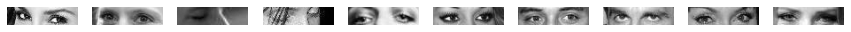

In [ ]:
# confirm position of eyes
plt.figure(figsize=(15,3))
for k in range(10):
    im = iio.imread(img_train[k]).astype(float)[100:120,50:130]
    im = np.mean(im, axis=2)
    plt.subplot(1,10,k+1)
    plt.imshow(im/255., cmap="gray")
    plt.axis("off")

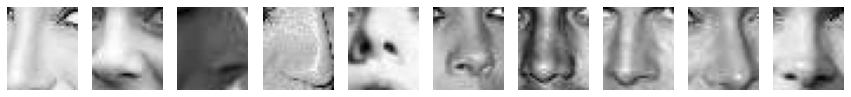

In [ ]:
# confirm position of nose
plt.figure(figsize=(15,3))
for k in range(10):
    im = iio.imread(img_train[k]).astype(float)[110:145,75:105]
    im = np.mean(im, axis=2)
    plt.subplot(1,10,k+1)
    plt.imshow(im/255., cmap="gray")
    plt.axis("off")

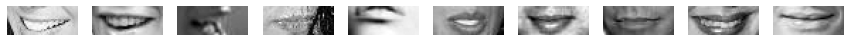

In [ ]:
# confirm position of mouth
plt.figure(figsize=(15,3))
for k in range(10):
    im = iio.imread(img_train[k]).astype(float)[145:165,65:115]
    im = np.mean(im, axis=2)
    plt.subplot(1,10,k+1)
    plt.imshow(im/255., cmap="gray")
    plt.axis("off")

In [ ]:
# define a new function to read in a specific part of each image.
def readimgreducedim_specific(filepath, y1, y2, x1, x2, enhance_contrast = True, convert_grayscale = True):
    img = iio.imread(filepath).astype(float)/255
        
    if enhance_contrast:
        img = equalize_adapthist(img)
    
    if convert_grayscale:
        img = rgb2gray(img)
        
    img = img[y1:y2,x1:x2].reshape((1,-1))
    return img

In [ ]:
eyes = (100,120,50,130)
train_eyes = Parallel(n_jobs = -2)(delayed(readimgreducedim_specific)(f, *eyes) for f in img_train)
train_eyes = np.vstack(train_eyes)
test_eyes = Parallel(n_jobs = -2)(delayed(readimgreducedim_specific)(f, *eyes) for f in img_test)
test_eyes = np.vstack(test_eyes)

nose = (110,145,75,105)
train_nose = Parallel(n_jobs = -2)(delayed(readimgreducedim_specific)(f, *nose) for f in img_train)
train_nose = np.vstack(train_nose)
test_nose = Parallel(n_jobs = -2)(delayed(readimgreducedim_specific)(f, *nose) for f in img_test)
test_nose = np.vstack(test_nose)

mouth = (145,165,65,115)
train_mouth = Parallel(n_jobs = -2)(delayed(readimgreducedim_specific)(f, *mouth) for f in img_train)
train_mouth = np.vstack(train_mouth)
test_mouth = Parallel(n_jobs = -2)(delayed(readimgreducedim_specific)(f, *mouth) for f in img_test)
test_mouth = np.vstack(test_mouth)

In [ ]:
print('\nFitting eyes model')
mom_train_acc_eyes, mom_test_acc_eyes, mom_lr_eyes, mom_loss_eyes, mom_weights_eyes = \
trainmodel(train_eyes, attr_train, test_eyes, attr_test, lossGrad, momentumgd, batchsize = 128, \
           epochs = 300, lr = 0.001, momentum = 0.8)
print('\nFitting nose model')
mom_train_acc_nose, mom_test_acc_nose, mom_lr_nose, mom_loss_nose, mom_weights_nose = \
trainmodel(train_nose, attr_train, test_nose, attr_test, lossGrad, momentumgd, batchsize = 128, \
           epochs = 300, lr = 0.001, momentum = 0.8)
print('\nFitting mouth model')
mom_train_acc_mouth, mom_test_acc_mouth, mom_lr_mouth, mom_loss_mouth, mom_weights_mouth = \
trainmodel(train_mouth, attr_train, test_mouth, attr_test, lossGrad, momentumgd, batchsize = 128, \
           epochs = 300, lr = 0.001, momentum = 0.8)


Fitting eyes model
Epoch: 0, Train Accuracy: 0.653 | Test Accuracy: 0.657
Epoch: 100, Train Accuracy: 0.878 | Test Accuracy: 0.885
Epoch: 200, Train Accuracy: 0.880 | Test Accuracy: 0.885
Final Epoch, Train Accuracy: 0.882 | Test Accuracy: 0.886

Fitting nose model
Epoch: 0, Train Accuracy: 0.588 | Test Accuracy: 0.591
Epoch: 100, Train Accuracy: 0.781 | Test Accuracy: 0.780
Epoch: 200, Train Accuracy: 0.794 | Test Accuracy: 0.792
Final Epoch, Train Accuracy: 0.797 | Test Accuracy: 0.796

Fitting mouth model
Epoch: 0, Train Accuracy: 0.657 | Test Accuracy: 0.662
Epoch: 100, Train Accuracy: 0.758 | Test Accuracy: 0.754
Epoch: 200, Train Accuracy: 0.765 | Test Accuracy: 0.759
Final Epoch, Train Accuracy: 0.767 | Test Accuracy: 0.759


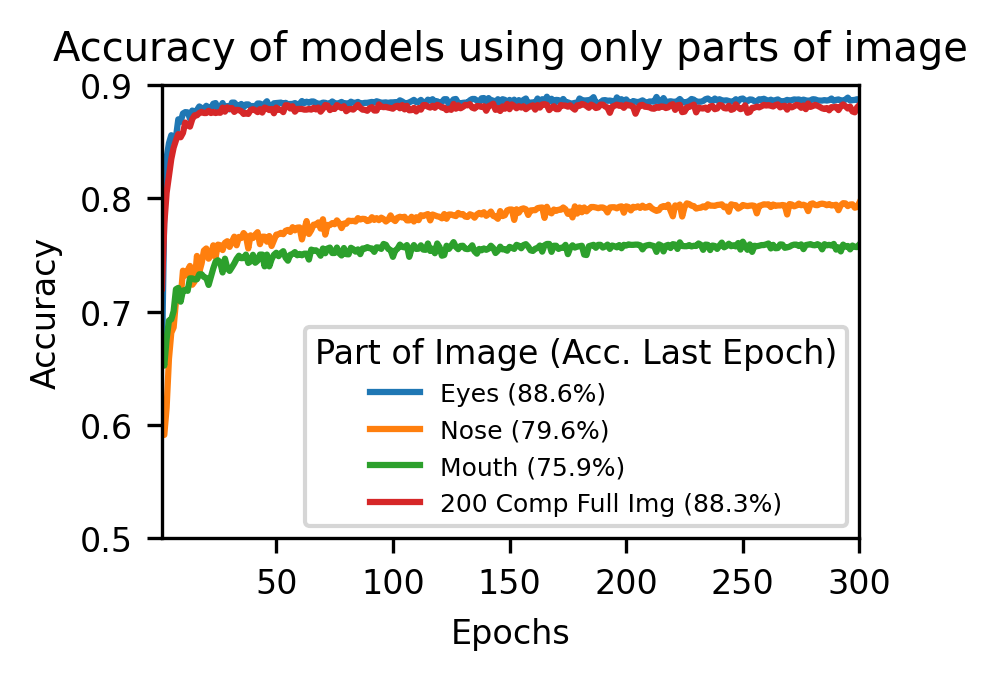

In [ ]:
plt.figure(figsize=(3,2))
plt.margins(0,0)
plt.rcParams['font.size'] = '8'
plt.gcf().set_dpi(300)
plt.plot(np.arange(300)+1,mom_test_acc_eyes, label=f'Eyes ({np.round(mom_test_acc_eyes[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc_nose, label=f'Nose ({np.round(mom_test_acc_nose[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc_mouth, label=f'Mouth ({np.round(mom_test_acc_mouth[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc_150px, label=f'200 Comp Full Img ({np.round(mom_test_acc_150px[-1]*100,1)}%)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.5,0.9])
plt.title('Accuracy of models using only parts of image')
plt.legend(title='Part of Image (Acc. Last Epoch)', prop = {'size':6}, loc = 4)
plt.show()

We noted that among models trained on images of eyes, mouth or nose, the highest test accuracy that was be achieved with an **eyes-only** model. The accuracy of the eyes-only model is higher than the 88% accuracy on our next-best model, Logistic Regression with GD with momentum using the full image.

We can infer from this result that eyes of a person in each image has significant informative value in the classification of gender, as compared to other features like eyes and nose.

## Question 5

**Is it useful to use an ensemble of models (eg. for example, you can use a different model for each part of the face, and then try to find a way to ensemble these models)?**

We utilise the eyes, nose and mouth models to create a Voting Classifier and predict the labels of the test set, with the ensemble model outputting the class (Male/Female) that is chosen by the majority of the classifiers. Then, we compare the accuracy of the voting classifier against the PCA model which utilized full images and each component model of the voting classifier.

In [ ]:
# get predictions from each model
eyes_preds = np.array(predictAll(mom_weights_eyes, test_eyes))
nose_preds = np.array(predictAll(mom_weights_nose, test_nose))
mouth_preds = np.array(predictAll(mom_weights_mouth, test_mouth))

In [ ]:
# get voting classification
vote_pred = []
for i in range(len(eyes_preds)):
  # count positives and negatives
    count_pos = 0
    count_neg = 0
    
    preds = list([eyes_preds[i], nose_preds[i], mouth_preds[i]])

    for j in preds:
        if j == 1:
            count_pos += 1
        elif j == -1:
            count_neg += 1
            
    if count_pos > count_neg:
        vote_pred.append(1)
    else:
        vote_pred.append(-1)
        
vote_pred = np.array(vote_pred)
vote_acc = np.mean(attr_test == vote_pred)
print(f'The voting model has a test accuracy of: {100*vote_acc:.2f}%')

The voting model has a test accuracy of: 86.28%


We noted from the results,that a voting classifier using three models for eyes, nose and mouth has lower test accuracy (\~86%) than an eyes-only model (\~89%).

## Question 6
**Report the error rate and AUC of your best model (when evaluated on the last 5,000 images)**

Our PCA model with 600 PCA components generated from colour images performed the best, with an error rate of ~8.9%. The ROC curve and AUC is presented below.

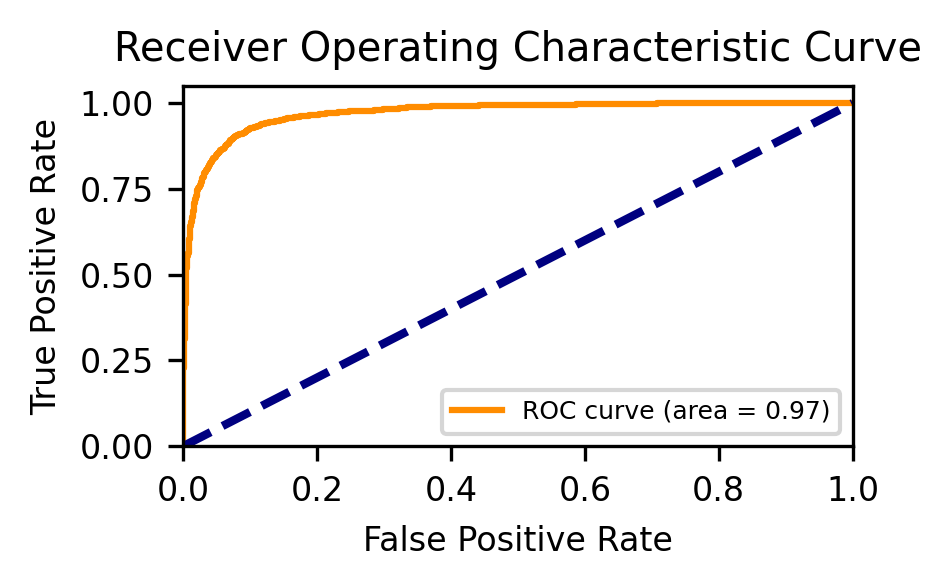

In [ ]:
best_preds = np.array(predictAllLogits(mom_weights_150px_c6, test_150x150_c6))
fpr, tpr, thresh = roc_curve(attr_test, best_preds)
auc = roc_auc_score(attr_test, best_preds)
plt.figure(figsize=(3,2))
plt.rcParams['font.size'] = '8'
plt.gcf().set_dpi(300)
plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {round(auc,2)})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right", prop={'size':6})
plt.tight_layout()
plt.show()

## Question 7
**Suppose now that you can only use 1% of the data, i.e. only the first 200 images, to train your model. What is the best model you can come up with? Is it helpful to use data-augmentation strategies? Is it helpful to use regularization strategies? Ensembling? Report the error rate and AUC of your best model (when evaluated on the last 5,000 images).**

Since we are only training on 200 training samples, we will be limited to 200 PCA components. Thus, when training the limited training samples model, we will compare its performance to the next most similar model that had 200 PCA components and 150x150px color images (trained for question 3).

In [ ]:
# set max number of images
n_train_lim = 200

train_150x150_lim, test_150x150_lim = gendatasets(img_train[:n_train_lim], img_test, imgsize = 150, n_components = 200, \
                                              enhance_contrast = True, convert_grayscale = False, n_samples = 200)

attr_train_lim = attr_train[:n_train_lim]

Fitting PCA 150px 200 PCA Components
Generating Train Set 150px 200 PCA Components
Generating Test Set 150px 200 PCA Components


In [ ]:
print('\nFitting 150x150px model with 1000 components and colour image input, limited to first 200 images for training')
mom_train_acc_150px_lim, mom_test_acc_150px_lim, mom_lr_150px_lim, mom_loss_150px_lim, mom_weights_150px_lim = \
trainmodel(train_150x150_lim, attr_train_lim, test_150x150_lim, attr_test, lossGrad, momentumgd, batchsize = 128, \
           epochs = 300, lr = 0.001, momentum = 0.8)


Fitting 150x150px model with 200 components and colour image input, limited to first 200 images for training
Epoch: 0, Train Accuracy: 0.435 | Test Accuracy: 0.444
Epoch: 100, Train Accuracy: 0.995 | Test Accuracy: 0.768
Epoch: 200, Train Accuracy: 1.000 | Test Accuracy: 0.782
Final Epoch, Train Accuracy: 1.000 | Test Accuracy: 0.785


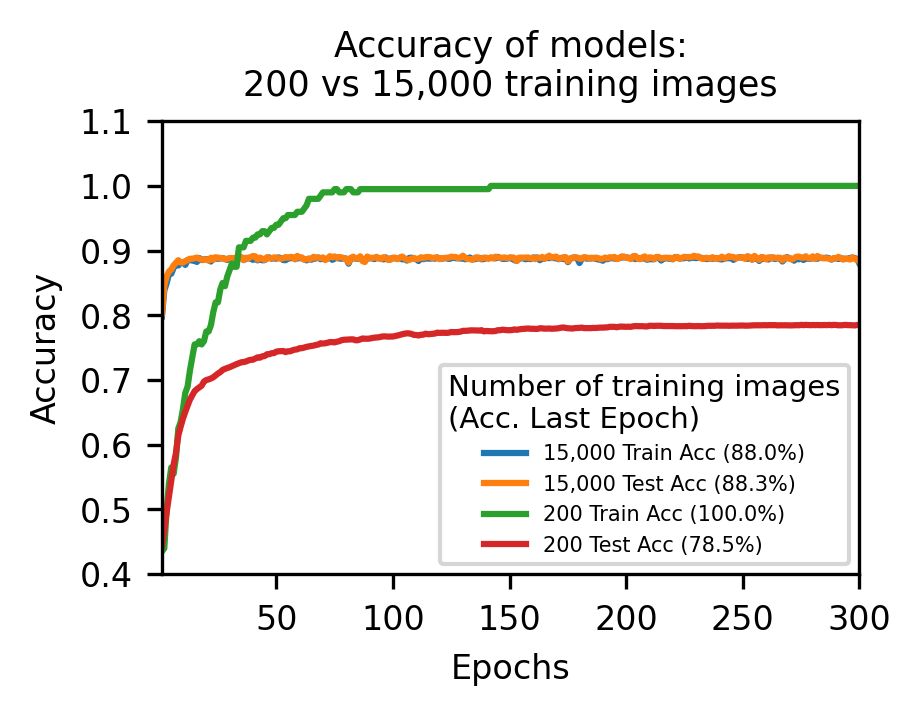

In [ ]:
plt.figure(figsize=(3,2))
plt.margins(0,0)
plt.rcParams['font.size'] = '7'
plt.gcf().set_dpi(300)
plt.plot(np.arange(300)+1,mom_train_acc_150px_c2, label=f'15,000 Train Acc ({np.round(mom_train_acc_150px_c2[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc_150px_c2, label=f'15,000 Test Acc ({np.round(mom_test_acc_150px_c2[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_train_acc_150px_lim, label=f'200 Train Acc ({np.round(mom_train_acc_150px_lim[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc_150px_lim, label=f'200 Test Acc ({np.round(mom_test_acc_150px_lim[-1]*100,1)}%)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.4,1.1])
plt.title('Accuracy of models:\n200 vs 15,000 training images')
plt.legend(title='Number of training images\n(Acc. Last Epoch)', prop = {'size':5}, loc = 4)
plt.show()

We see that the model trained with just 200 training images gets overfitted to the training set, with 100% accuracy on the training set, but test accuracy that is only 78.2%. 

As there were only 200 images to work with, it becomes a challenge to extract principal components from the training set that are also releveant to other samples, thus explaining the poor accuracy on the test set.

The ROC curve and AUC (0.86) of the limited training samples model is presented in the chart below.

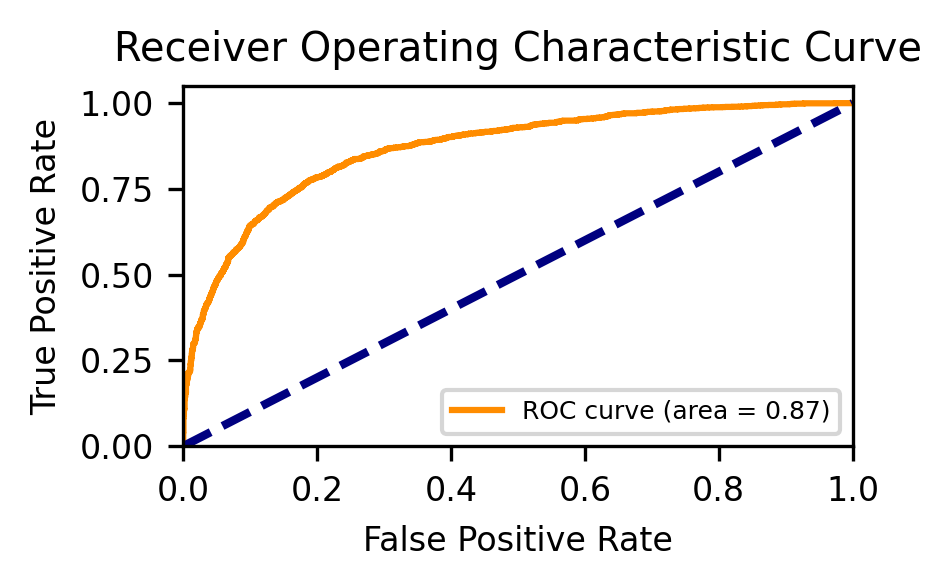

In [ ]:
best_preds = np.array(predictAllLogits(mom_weights_150px_lim, test_150x150_lim))
fpr, tpr, thresh = roc_curve(attr_test, best_preds)
auc = roc_auc_score(attr_test, best_preds)
plt.figure(figsize=(3,2))
plt.rcParams['font.size'] = '8'
plt.gcf().set_dpi(300)
plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {round(auc,2)})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right", prop={'size':6})
plt.tight_layout()
plt.show()

Let us try to improve the performance of this model using data augmentation via the Albumentations package.

In [ ]:
import random
#If Albumentations is not installed: pip install albumentations
import albumentations as A

Because of the nature of logistic regression, it would not be advisable to use image augmentations that rearrange the spatial position of the pixels in the photos too drastically (e.g. rotating 90 degrees). Instead, we choose to use only transformations that change the colour (FancyPCA, HueSaturationValue), contrast (CLAHE, RandomBrightnessContrast) and sharpness (Blur) of the image, as well as the horizontal flip, which maintains the general position of the salient parts of the faces (eyes, ears, nose, mouth, etc.).

In [ ]:
transform_aug = A.Compose([
    A.FromFloat(max_value=255.,dtype=np.uint8),
    A.HorizontalFlip(),
    A.CLAHE(),
    A.OneOf([A.FancyPCA(), A.HueSaturationValue()]),
    A.RandomBrightnessContrast(),
    A.Blur(blur_limit=5),
    A.ToFloat(max_value=255.)
])
    
resize_img = A.Compose([
    A.ToFloat(max_value=255.),
    A.Resize(150, 150, p=1.),
])

In [ ]:
random.seed(0) # For repeatability

augment_factor = 20 # generate these many new images from each original training image (not inclusive of the original)

In [ ]:
attr_aug = np.hstack([[attr for _ in range(augment_factor)] for attr in attr_train[:n_train_lim]])
attr_aug = np.hstack((attr_aug, attr_train[:n_train_lim]))

img_in = Parallel(n_jobs=-2)(delayed(iio.imread)(img) for img in img_train[:n_train_lim])
img_in = [resize_img(image=img)["image"] for img in img_in]

img_testing = Parallel(n_jobs=-2)(delayed(iio.imread)(img) for img in img_test)
img_testing = np.vstack([np.reshape(resize_img(image=img)["image"],-1) for img in img_testing])

img_aug = np.vstack([[np.reshape(transform_aug(image=img)["image"], -1) for i in range(augment_factor)] for img in img_in])
img_aug = np.vstack((img_aug, [np.reshape(img,-1) for img in img_in]))

We can visualise the first 10 augmentations for the first training image.

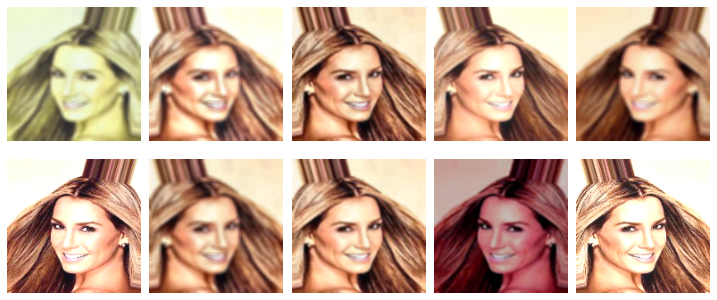

In [ ]:
fig,axs = plt.subplots(2,5,figsize=(10,5), tight_layout=True)

for i in range(10):
    axs.flat[i].imshow(np.reshape(img_aug[i],(150,150,3)))
    axs.flat[i].set(frame_on=False, xticks=[], yticks=[])

As with the non-data-limited case, we construct a PCA decomposition using a random choice of 1000 of the (augmented) training images. From these 1000 images, we generate 1000 principal components.

In [ ]:
np.random.seed(0)
pca_indices = np.random.choice(img_aug.shape[0], size=1000, replace=False)
pca_imgdata = img_aug[pca_indices,:]

pca = PCA(n_components=1000)
PCA_transformer = pca.fit(pca_imgdata)

In [ ]:
train_aug = PCA_transformer.transform(img_aug)
test_aug = PCA_transformer.transform(img_testing)

print('\nFitting 150x150px model with 1000 components and colour image input, limited to first 200 images for training, plus augmentation')
mom_train_acc_150px_aug, mom_test_acc_150px_aug, mom_lr_150px_aug, mom_loss_150px_aug, mom_weights_150px_aug = \
trainmodel(train_aug, attr_aug, test_aug, attr_test, lossGrad, momentumgd, batchsize = 128, \
           epochs = 300, lr = 0.001, momentum = 0.8)


Fitting 150x150px model with 1000 components and colour image input, limited to first 200 images for training, plus augmentation
Epoch: 0, Train Accuracy: 0.800 | Test Accuracy: 0.713
Epoch: 100, Train Accuracy: 1.000 | Test Accuracy: 0.827
Epoch: 200, Train Accuracy: 1.000 | Test Accuracy: 0.831
Final Epoch, Train Accuracy: 1.000 | Test Accuracy: 0.832


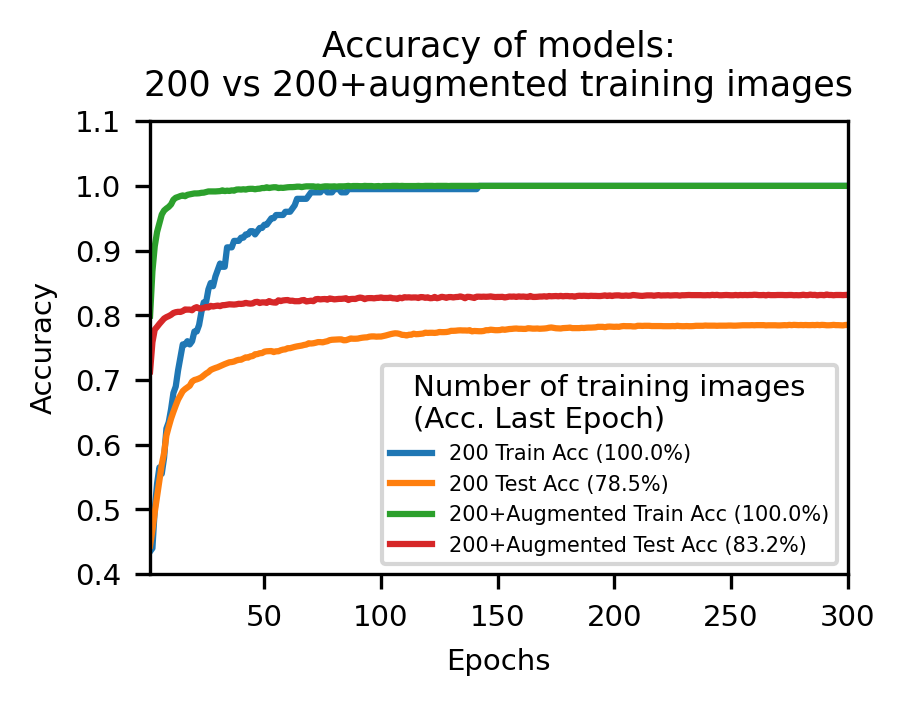

In [ ]:
plt.figure(figsize=(3,2))
plt.margins(0,0)
plt.rcParams['font.size'] = '7'
plt.gcf().set_dpi(300)
plt.plot(np.arange(300)+1,mom_train_acc_150px_lim, label=f'200 Train Acc ({np.round(mom_train_acc_150px_lim[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc_150px_lim, label=f'200 Test Acc ({np.round(mom_test_acc_150px_lim[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_train_acc_150px_aug, label=f'200+Augmented Train Acc ({np.round(mom_train_acc_150px_aug[-1]*100,1)}%)')
plt.plot(np.arange(300)+1,mom_test_acc_150px_aug, label=f'200+Augmented Test Acc ({np.round(mom_test_acc_150px_aug[-1]*100,1)}%)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.4,1.1])
plt.title('Accuracy of models:\n200 vs 200+augmented training images')
plt.legend(title='Number of training images\n(Acc. Last Epoch)', prop = {'size':5}, loc = 4)
plt.show()

We see that the test accuracy is around 83%, which is an improvement from the figure without augmentation (78.5%).

An explanation for this would be that the data augmentation allowed for a more robust set of principal components to be generated, which manages to capture the structure of human faces while not being overly biased due to variations in lighting or colour balance.

The ROC curve and AUC (0.9) of the model using data augmentation is presented below.

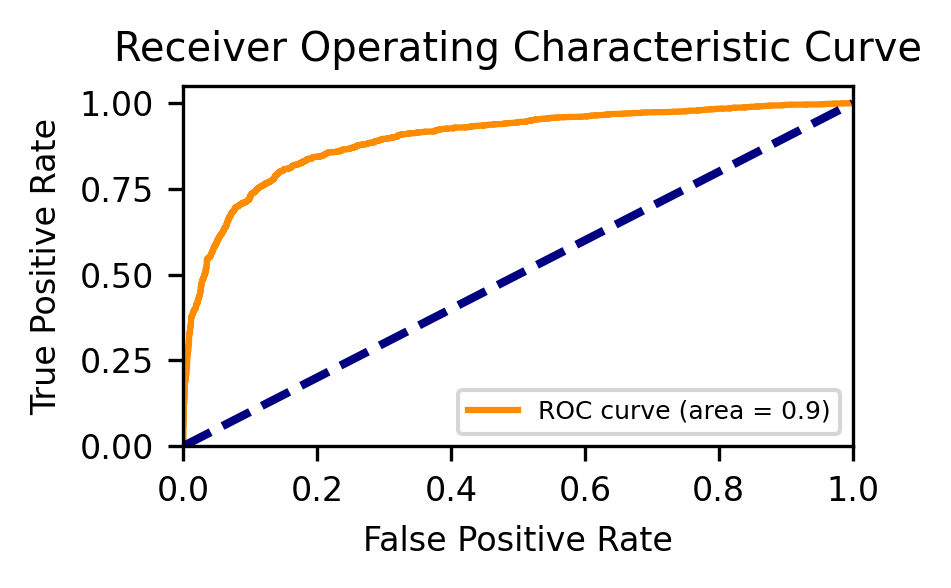

In [ ]:
best_preds = np.array(predictAllLogits(mom_weights_150px_aug, test_aug))
fpr, tpr, thresh = roc_curve(attr_test, best_preds)
auc = roc_auc_score(attr_test, best_preds)
plt.figure(figsize=(3,2))
plt.rcParams['font.size'] = '8'
plt.gcf().set_dpi(300)
plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {round(auc,2)})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right", prop={'size':6})
plt.tight_layout()
plt.show()